In [47]:
titles = list(Work.objects.filter(category__slug='anime').order_by('title').values_list('title', flat=True))
len(titles)

24809

In [86]:
import random

offset = random.randint(0, len(titles) - 100)
#offset = 8975

In [87]:
subset = titles[offset:offset + 20]
for title in subset:
    print(title)

Isobe Isobee Monogatari: Ukiyo wa Tsurai yo (2015)
Isobe Isobee with Nakata Yasutaka de Sourou
Isourou Tengoku
I''s Pure
I``s Pure
I''s Pure Bonus
Issei Kiyuukyoku: Divertimento
Issho ni Ecchi
Issho ni H Shiyo
Issho ni Sleeping: Sleeping with Hinako
Issho ni Training Ofuro: Bathtime with Hinako & Hiyoko
Issho ni Training: Training with Hinako
Isshuukan Friends. Kaori no Nikki
Isshuukan Friends. Specials
Isshuukan Friends.: Tomodachi to no Omoide
Issunboushi
Issunboushi (1956)
Issunboushi (2007)
Issunboushi: Chibi Jo Monogatari
Is the order a rabbit?


In [88]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = vec.fit_transform(subset)

In [89]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(X)

CPU times: user 6.75 ms, sys: 514 µs, total: 7.27 ms
Wall time: 4.74 ms


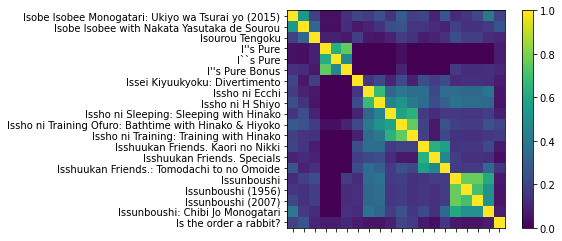

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.imshow(sim)
plt.colorbar()
t = np.arange(len(subset))
plt.yticks(t, subset)
plt.xticks(t, [])
plt.show()

## Artist objects with same name or first name/last name inversed

In [1]:
from collections import Counter

c = Counter()
for name in Artist.objects.values_list('name', flat=True):
    c[' '.join(sorted(name.lower().split()))] += 1
meta = Counter(c.values())
for k, v in meta.most_common():
    print(k, 'occurrence :', v, 'artiste(s)')
print()
for k, v in c.most_common():
    if v >= 3:
        print(k, ':', v, 'occurrences')

1 occurrence : 2445 artiste(s)
2 occurrence : 83 artiste(s)
3 occurrence : 6 artiste(s)
4 occurrence : 2 artiste(s)

kawahara reki : 4 occurrences
harold sakuishi : 4 occurrences
araki hirohiko : 3 occurrences
otonaka sawaki : 3 occurrences
akira toriyama : 3 occurrences
miki yoshikawa : 3 occurrences
sukeno yoshiaki : 3 occurrences
ai yazawa : 3 occurrences


## How many works share a title

In [3]:
c = Counter(Work.objects.values_list('title', 'category__slug'))
for k, v in c.most_common():
    if v >= 3:  # If 2 then there are too many
        print(k, v)

('The Asterisk War: The Academy City on the Water', 'anime') 9
('Dororo', 'anime') 4
('Zatch Bell!', 'anime') 4
('Yakusoku', 'anime') 4
('Sorcerer Hunters', 'anime') 3
('Naita Aka Oni', 'anime') 3
('Meat or Die', 'anime') 3
('Saru Kani Gassen', 'anime') 3
('Shiroi Zou', 'anime') 3
('Meow no Hoshi', 'anime') 3
('Those Who Hunt Elves', 'anime') 3
('Digimon: The Movie', 'anime') 3
('Yu-Gi-Oh!', 'anime') 3
('Mottainai', 'anime') 3
('Mikagura Gakuen Kumikyoku', 'anime') 3
('Dragon Quest: Dai no Daibouken', 'anime') 3
('Street Fighter Zero: The Animation', 'anime') 3
('Desert Punk', 'anime') 3
('Imawa no Kuni no Alice', 'anime') 3
('DRAMAtical Murder OVA: Data_xx_Transitory', 'anime') 3
('Nekopara', 'anime') 3
('Black Clover', 'anime') 3
('Fastening Days', 'anime') 3
('Shiranpuri', 'anime') 3
('Kekkaishi', 'anime') 3
('Hunter x Hunter', 'anime') 3
('Dimension W', 'anime') 3
('Shinpi no Sekai El Hazard', 'anime') 3
('Mahou Tsukai Tai!', 'anime') 3
('Yamada-kun to 7-nin no Majo', 'anime') 3
('

### What about alternative titles?

In [4]:
nb = 0
alt_titles = dict(WorkTitle.objects.values_list('title', 'work_id'))
pairs = []
for work_id, title in Work.objects.filter(title__in=alt_titles.keys()).values_list('id', 'title'):
    if work_id != alt_titles[title]:
        pairs.append((work_id, alt_titles[title]))

In [5]:
import numpy as np

works = Work.objects.in_bulk(list(np.array(pairs).flatten()))

In [8]:
len(pairs)

1479

In [7]:
for work_id, work_id2 in pairs[:10]:
    if works[work_id].title != works[work_id2].title:
        print(work_id, works[work_id].title, '/', works[work_id2].title, work_id2)

21458 Lupin the IIIrd: Chikemuri no Ishikawa Goemon / Lupin III: Goemon Ishikawa's Spray of Blood 28327
233 Doraemon / Doraemon (1979) 11292
13471 Haikyuu!!: Jump Festa 2015 Special / Haikyuu!!: vs. "Akaten" 25374
13827 Pandora in the Crimson Shell: Ghost Urn / Koukaku no Pandora: Ghost Urn 27797
2951 I love BuBu ChaCha / Daisuki! Bubu- Chacha 23460
2983 UFO Ultramaiden Valkyrie 4: Banquet of Time, Dreams, and Galaxies / UFO Princess Valkyrie: Toki to Yume to Ginga no Utage 34014
1177 Porong Porong Pororo / Bbororoe Daemoheom 22450
3254 Great Yamato No. 0 / Dai Yamato Zero-go 23443
3286 Fly, Space Battleship Geobukseon / Narara Ujujeonham Geobukseon 29626
2118 Voltage Fighter Gowcaizer / Choujin Gakuen Gowcaizer 23159


## How many works share a reference?

In [9]:
from django.db.models import Count

def describe(queryset):
    nb_distinct_fields = queryset.filter(nb__gte=2).count()
    nb_duplicates = sum(queryset.filter(nb__gte=2).values_list('nb', flat=True))
    print('{:d} oeuvres partagent {:d} champs'.format(nb_duplicates, nb_distinct_fields))

In [10]:
queryset = Work.objects.values('reference__url').annotate(nb=Count('reference__url')).order_by('-nb')
describe(queryset)

575 oeuvres partagent 281 champs


Donc en septembre 2018, 577 œuvres partagent 282 références. Peut-être encore des doublons à écarter.

## How many works have same poster?

In [11]:
queryset = Work.objects.filter(ext_poster__endswith='.jpg').values('ext_poster').annotate(nb=Count('ext_poster')).order_by('-nb')
queryset[:5]

<WorkQuerySet [{'ext_poster': 'https://cdn.anidb.net/images/main/165165.jpg', 'nb': 3}, {'ext_poster': 'https://s4.anilist.co/file/anilistcdn/media/anime/cover/medium/default.jpg', 'nb': 3}, {'ext_poster': 'https://cdn.anidb.net/images/main/231328.jpg', 'nb': 3}, {'ext_poster': 'http://www.manga-news.com/public/images/series/dragonhuntercoffret1gd.jpg', 'nb': 2}, {'ext_poster': 'https://cdn.anidb.net/images/main/11295.jpg', 'nb': 2}]>

In [12]:
describe(queryset)

99 oeuvres partagent 48 champs


## How many works have same AniDB ID?

In [13]:
queryset = Work.objects.exclude(anidb_aid=0).values('anidb_aid').annotate(nb=Count('anidb_aid')).order_by('-nb')
queryset[:5]

<WorkQuerySet [{'anidb_aid': 4932, 'nb': 6}, {'anidb_aid': 8778, 'nb': 3}, {'anidb_aid': 6747, 'nb': 2}, {'anidb_aid': 4897, 'nb': 2}, {'anidb_aid': 9977, 'nb': 2}]>

In [14]:
describe(queryset)

35 oeuvres partagent 15 champs


In [15]:
Work.objects.filter(anidb_aid=4932)  # Lol ce n'est pas un doublon

<WorkQuerySet [<Work: Kara no Kyoukai 3: Tsuukaku Zanryuu>, <Work: Kara no Kyoukai 1: Fukan Fuukei>, <Work: Kara no Kyoukai 2: Satsujin Kousatsu (Part 1)>, <Work: Kara no Kyoukai 5: Mujun Rasen>, <Work: Kara no Kyoukai 4: Garan no Dou>, <Work: Kara no Kyoukai 7: Satsujin Kousatsu (Part 2)>]>

In [16]:
Work.objects.filter(anidb_aid=8778)  # Non plus

<WorkQuerySet [<Work: Puella Magi Madoka Magica the Movie Part 3: Rebellion>, <Work: Puella Magi Madoka Magica the Movie Part 1: Beginnings>, <Work: Puella Magi Madoka Magica the Movie Part 2: Eternal>]>

## How many anime have an AniDB ID?

In [17]:
nb_anidb_works = Work.objects.exclude(anidb_aid=0).count()
nb_anidb_works

5785

In [18]:
nb_anidb_works / Work.objects.filter(category__slug='anime').count()

0.23318150671127413

## How many works have at least one Reference?

In [19]:
Work.objects.annotate(nb=Count('reference')).values('id').filter(nb__gte=1).count() / Work.objects.count()

0.8687271858902194

In [20]:
for category in Category.objects.all():
    print(category.slug)
    category_works = Work.objects.filter(category=category)
    nb = category_works.annotate(nb=Count('reference')).values('id').filter(nb__gte=1).count()
    print('{:d}/{:d} = {:.1f} %'.format(nb, category_works.count(), 100 * nb / category_works.count()))

anime
24788/24809 = 99.9 %
manga
677/4503 = 15.0 %
album
0/1 = 0.0 %
